<a href="https://colab.research.google.com/github/berthine/Research_Project_T-bingen_Cg/blob/main/ChestMNIST_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ** Pipeline to predict the 14 classes from the x-rays of the chest MNIST dataset**

ChestMNIST is a dataset with images of chest X-rays with labels identifying if each of these images have one of 14 classes. It has 112000 images such as 70% for training, 10% for validation, and 20% for testing.

In [31]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
import torchvision.models as models
from sklearn.metrics import roc_auc_score, accuracy_score

In [4]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
chest = np.load("/content/drive/MyDrive/Tubingen_Research/chestmnist.npz")

In [6]:
chest.files

['train_images',
 'val_images',
 'test_images',
 'train_labels',
 'val_labels',
 'test_labels']

In [7]:
chest['train_images'].shape

(78468, 28, 28)

In [8]:
chest['train_labels'].shape

(78468, 14)

In [8]:
chest_train_images = chest['train_images']
chest_train_labels = chest['train_labels']
chest_test_images = chest['test_images']
chest_test_labels = chest['test_labels']

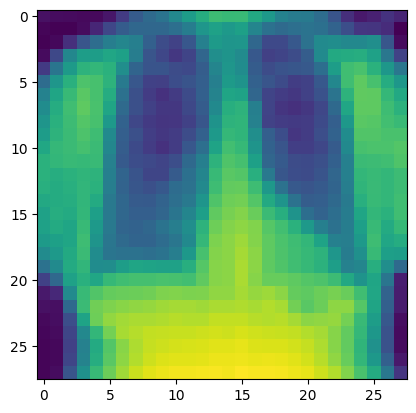

In [9]:
#let's visualize an image

plt.imshow(chest['train_images'][10], interpolation='nearest')
# plt.gray()
plt.show()

In [10]:
chest['train_images'][10].size

784

In [11]:
28*28

784

In [12]:
chest['train_labels']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [13]:
class MyDataset(Dataset):
  def __init__(self, x, y, transform=None, as_rgb=True):
    super().__init__()
    self.x = x
    self.y = y
    self.transform = transform
    self.as_rgb = as_rgb

  def __getitem__(self, idx):
    img, target = self.x[idx], self.y[idx].astype(int)
    img = Image.fromarray(img)
    if self.as_rgb:
        img = img.convert('RGB')

    if self.transform is not None:
        img = self.transform(img)

    return img, target

  def __repr__(self):
    return "This is the chest MNIST dataset and it has length {}".format(len(self))

  def __len__(self):
    assert len(self.x) == len(self.y)
    return len(self.y)

### Step 1: Resize image to 3x224x224

In [14]:
data_transform = transforms.Compose(
    [transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])])

my_dataset = MyDataset(chest['train_images'], chest['train_labels'], transform=data_transform)
my_dataloader = DataLoader(my_dataset, batch_size=128, shuffle=True)


In [15]:
my_dataset

This is the chest MNIST dataset and it has length 78468

In [16]:
val_dataset = MyDataset(chest['val_images'], chest['val_labels'], transform=data_transform)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = MyDataset(chest['test_images'], chest['test_labels'], transform=data_transform)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

label_mapping = ['atelectasis', 'cardiomegaly', 'effusion', 'infiltration', 'mass', 'nodule', 'pneumonia', 'pneumothorax', 'consolidation', 'edema', 'emphysema', 'fibrosis', 'pleural', 'hernia']


In [17]:
from torchvision.models import resnet18
net = resnet18(pretrained=False, num_classes=14)

# net

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
model_path = "/content/drive/MyDrive/Tubingen_Research/resnet18_224_3.pth"


In [19]:
net.load_state_dict(torch.load(model_path, map_location='cuda')['net'], strict=True)


<ipython-input-19-acda8685ffe5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path, map_location='cuda')['net'], strict=True)


<All keys matched successfully>

### Step 2: Load modified model

In [20]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])])

my_dataset = MyDataset(chest['train_images'], chest['train_labels'], transform=data_transform, as_rgb=True)
my_dataloader = DataLoader(my_dataset, batch_size=128)

val_dataset = MyDataset(chest['val_images'], chest['val_labels'], transform=data_transform)
val_dataloader = DataLoader(val_dataset, batch_size=128)

test_dataset = MyDataset(chest['test_images'], chest['test_labels'], transform=data_transform)
test_dataloader = DataLoader(test_dataset, batch_size=128)

label_mapping = ['atelectasis', 'cardiomegaly', 'effusion', 'infiltration', 'mass', 'nodule', 'pneumonia', 'pneumothorax', 'consolidation', 'edema', 'emphysema', 'fibrosis', 'pleural', 'hernia']



In [26]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channels=1, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(in_channels, num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels=in_channels, num_classes=num_classes)


In [28]:
import sys
sys.path.insert(0, '/chestMNIST')
# from models import ResNet18
net = ResNet18(in_channels=3, num_classes=14)

In [30]:
#Hyper parameters

num_epochs = 100
lr = 0.001
gamma=0.1
milestones = [0.5 * num_epochs, 0.75 * num_epochs]

# Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# Loss function (cross entropy for classification)
loss_func = nn.BCEWithLogitsLoss()

In [34]:
#Metrics
def getAUC(y_true, y_score):
    '''AUC metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    '''
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    auc = 0
    for i in range(y_score.shape[1]):
        label_auc = roc_auc_score(y_true[:, i], y_score[:, i])
        auc += label_auc
    ret = auc / y_score.shape[1]

    return ret

def getACC(y_true, y_score, threshold=0.5):
    '''Accuracy metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    :param threshold: the threshold for multilabel and binary-class tasks
    '''
    y_true = y_true.squeeze()
    y_score = y_score.squeeze()

    y_pre = y_score > threshold
    acc = 0
    for label in range(y_true.shape[1]):
        label_acc = accuracy_score(y_true[:, label], y_pre[:, label])
        acc += label_acc
    ret = acc / y_true.shape[1]

    return ret



In [33]:
def test(model, split_labels, data_loader, criterion, device='cuda', raw=False):
    model.cuda()
    model.eval()

    total_loss = []
    y_score = torch.tensor([]).to('cpu')
    with torch.no_grad():
        for batch in data_loader:
            # Forward pass
            inp, labels = batch
            inp = torch.tensor(inp.cuda(), dtype=torch.float32)
            out = model(inp)
            labels = labels.to(torch.float32).cuda()
            loss = criterion(out, labels)

            # Get predictions from scores
            sigmoid = torch.nn.Sigmoid()
            answers = sigmoid(out).data.cpu()

            # Recording values
            y_score = torch.cat((y_score, answers), 0)
            total_loss.append(loss.item())

        y_score = y_score.cpu().data.numpy()
        auc = getAUC(split_labels, y_score)
        acc = getACC(split_labels, y_score)

        testing_loss = np.mean(total_loss)

        if raw:
            return [testing_loss, auc, acc, split_labels, y_score]

        return [testing_loss, auc, acc]


In [35]:
net.cuda()

best_epoch = 0
best_auc = 0
best_model = net

for epoch in range(num_epochs): # We go over the data ten times
    losses = []
    net.train()
    for batch in my_dataloader:
        optimizer.zero_grad()

        # Forward pass
        inp, labels = batch
        inp = torch.tensor(inp.cuda(), dtype=torch.float32)
        out = net(inp)
        labels = labels.to(torch.float32).cuda()
        loss = loss_func(out, labels)
        losses.append(loss.item())

        # Backward pass
        loss.backward()
        optimizer.step()

    train_loss = np.mean(losses)
    val_metrics = test(net, chest['val_labels'], val_dataloader, loss_func)

    cur_auc = val_metrics[1]
    if cur_auc > best_auc:
        best_epoch = epoch
        best_auc = cur_auc
        best_model = net
        print(f"Epoch {best_epoch} is the best yet with Val AUC = {best_auc}")
        torch.save(best_model, '/content/drive/MyDrive/Tubingen_Research/chest_resnet18_225.pt')

    scheduler.step()

<ipython-input-35-0656d5c23622>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp.cuda(), dtype=torch.float32)
<ipython-input-33-4fcc2bee83af>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp.cuda(), dtype=torch.float32)


Epoch 0 is the best yet with Val AUC = 0.7316172522841612


<ipython-input-35-0656d5c23622>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp.cuda(), dtype=torch.float32)
<ipython-input-33-4fcc2bee83af>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp.cuda(), dtype=torch.float32)


Epoch 1 is the best yet with Val AUC = 0.7447070129809754


<ipython-input-35-0656d5c23622>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp.cuda(), dtype=torch.float32)
<ipython-input-33-4fcc2bee83af>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp.cuda(), dtype=torch.float32)


Epoch 2 is the best yet with Val AUC = 0.7538363815247449


<ipython-input-35-0656d5c23622>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp.cuda(), dtype=torch.float32)
<ipython-input-33-4fcc2bee83af>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp.cuda(), dtype=torch.float32)


Epoch 3 is the best yet with Val AUC = 0.756049733622867


<ipython-input-35-0656d5c23622>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp.cuda(), dtype=torch.float32)
<ipython-input-33-4fcc2bee83af>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp.cuda(), dtype=torch.float32)
<ipython-input-35-0656d5c23622>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp.cuda(), dtype=torch.float32)
<ipython-input-33-4fcc2bee83af>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or so

In [ ]:
# torch.save(net, 'chestMNIST/net4.pt')

In [36]:
from sklearn.metrics import *

test_metrics = test(net, chest['test_labels'], test_dataloader, loss_func, raw=True)



<ipython-input-33-4fcc2bee83af>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(inp.cuda(), dtype=torch.float32)


In [37]:
y_true, y_score = test_metrics[-2], test_metrics[-1]
print(f"Test AUC: {test_metrics[1]:5f} \nTest ACC: {test_metrics[2]:5f}")



Test AUC: 0.666443 
Test ACC: 0.939467


In [38]:
y_pre = y_score > 0.5
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pre, average='samples', zero_division=1)
print(f"Test Precision: {precision:.5f}\nTest Recall: {recall:.5f}\nTest F1: {f1:.5f}")



Test Precision: 0.84177
Test Recall: 0.58572
Test F1: 0.51180


In [39]:
for i in range(y_pre.shape[1]):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true[:, i], y_pre[:, i], average='micro', zero_division=1)
    print(f"Class {i}: Precision: {precision:.5f}\tRecall: {recall:.5f}\tF1: {f1:.5f}")


Class 0: Precision: 0.86408	Recall: 0.86408	F1: 0.86408
Class 1: Precision: 0.97134	Recall: 0.97134	F1: 0.97134
Class 2: Precision: 0.86823	Recall: 0.86823	F1: 0.86823
Class 3: Precision: 0.78991	Recall: 0.78991	F1: 0.78991
Class 4: Precision: 0.94285	Recall: 0.94285	F1: 0.94285
Class 5: Precision: 0.93242	Recall: 0.93242	F1: 0.93242
Class 6: Precision: 0.98881	Recall: 0.98881	F1: 0.98881
Class 7: Precision: 0.94459	Recall: 0.94459	F1: 0.94459
Class 8: Precision: 0.95119	Recall: 0.95119	F1: 0.95119
Class 9: Precision: 0.97896	Recall: 0.97896	F1: 0.97896
Class 10: Precision: 0.97517	Recall: 0.97517	F1: 0.97517
Class 11: Precision: 0.98302	Recall: 0.98302	F1: 0.98302
Class 12: Precision: 0.96385	Recall: 0.96385	F1: 0.96385
Class 13: Precision: 0.99813	Recall: 0.99813	F1: 0.99813


In [40]:
multilabel_confusion_matrix(y_true, y_pre, samplewise=False)



array([[[19016,   997],
        [ 2052,   368]],

       [[21731,   120],
        [  523,    59]],

       [[18719,   960],
        [ 1996,   758]],

       [[17147,  1348],
        [ 3365,   573]],

       [[21087,   213],
        [ 1069,    64]],

       [[20898,   200],
        [ 1316,    19]],

       [[22181,    10],
        [  241,     1]],

       [[21129,   215],
        [ 1028,    61]],

       [[21313,   163],
        [  932,    25]],

       [[21945,    75],
        [  397,    16]],

       [[21868,    56],
        [  501,     8]],

       [[22050,    21],
        [  360,     2]],

       [[21615,    84],
        [  727,     7]],

       [[22391,     0],
        [   42,     0]]])

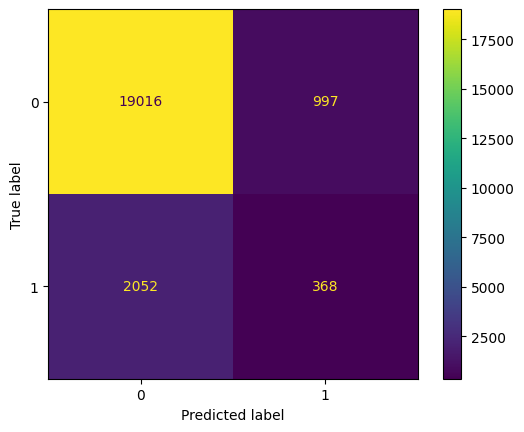

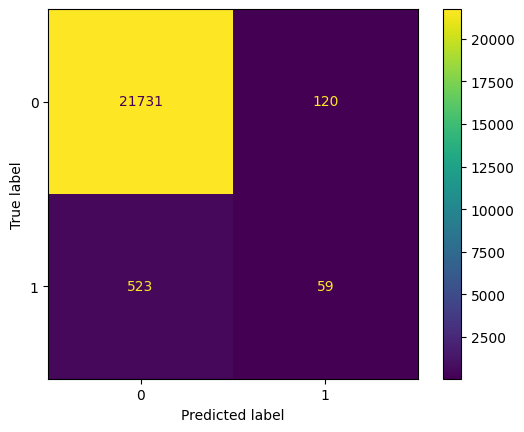

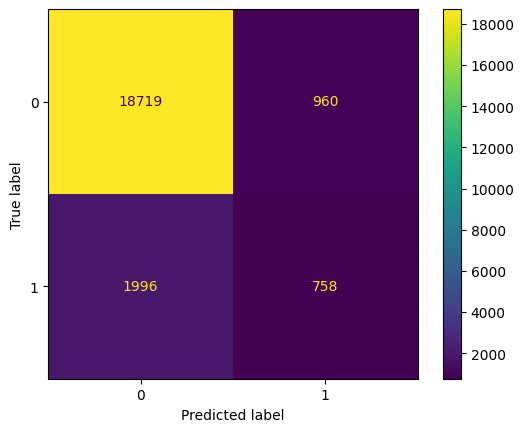

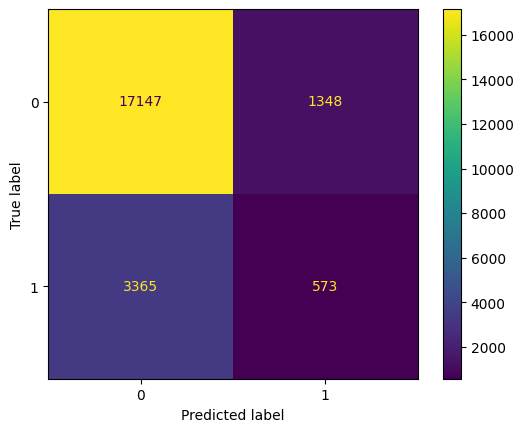

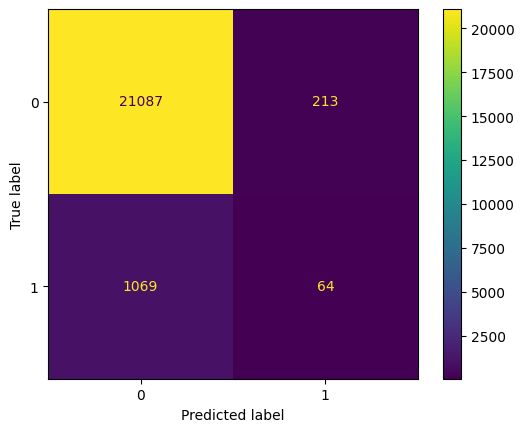

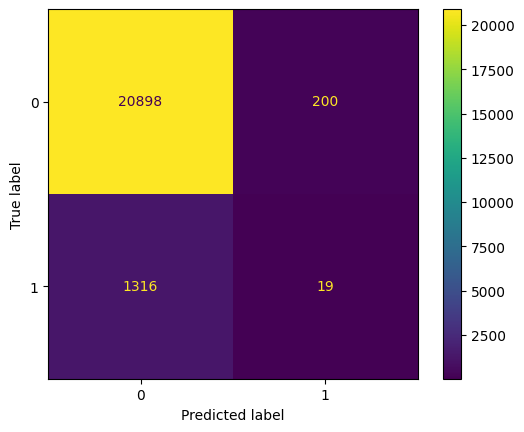

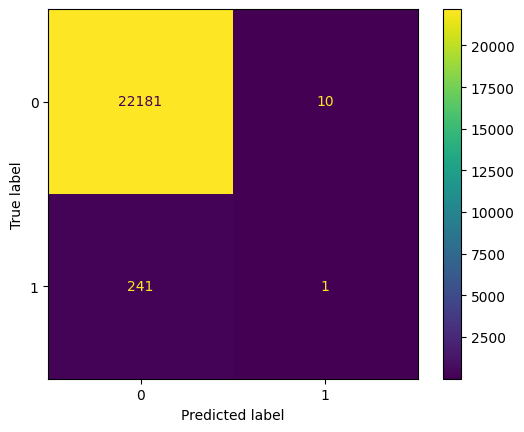

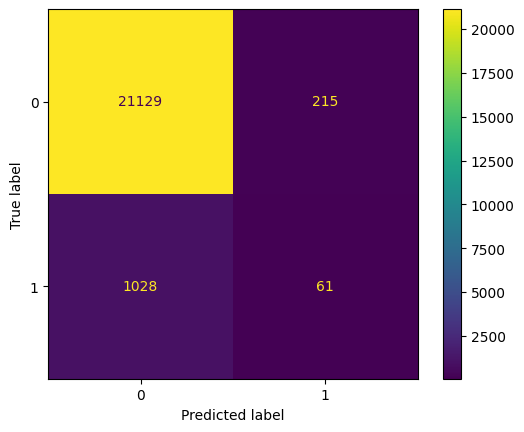

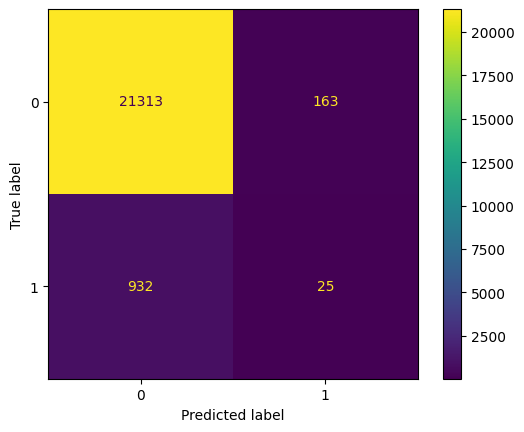

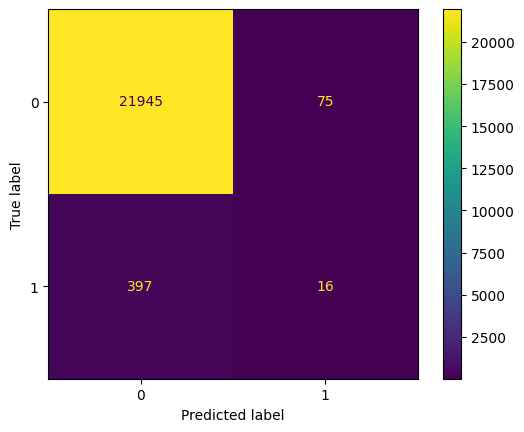

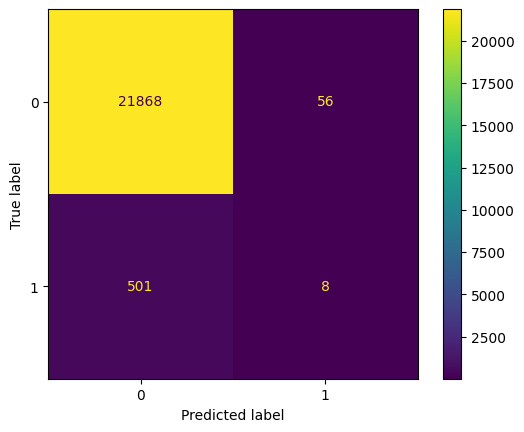

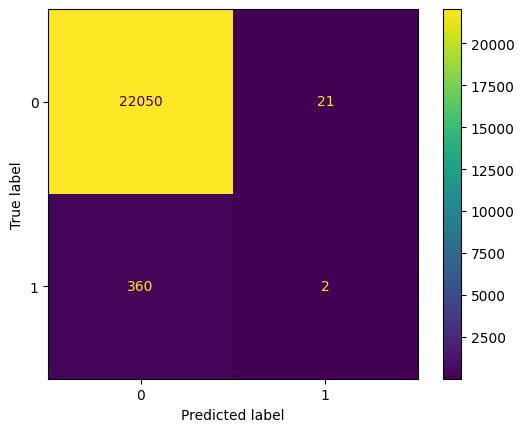

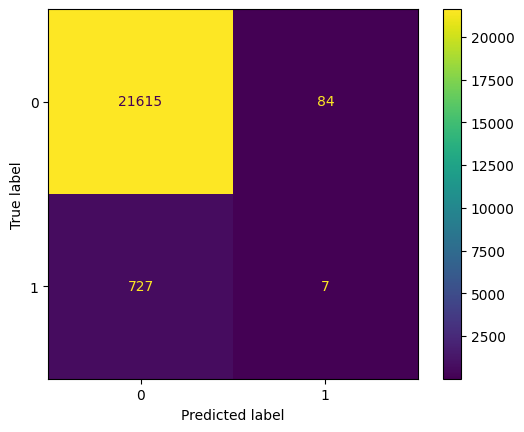

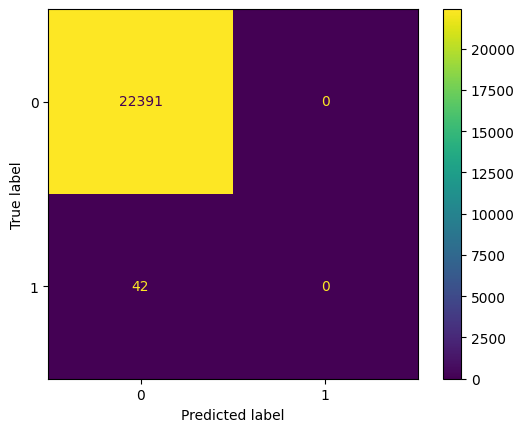

In [41]:
for i in range(y_score.shape[1]):
    ConfusionMatrixDisplay.from_predictions(y_true[:, i], y_pre[:, i])
